In [1]:
import numpy as np
import math
from math import factorial
from scipy.special import comb
import matplotlib.pyplot as plt

In [2]:
def SAM(A, y, w_0, rho, eta, k):
    n, d = A.shape
    w = w_0.copy()

    for _ in range(k):
        grad_w = A.T@(A@w - y.reshape(-1))
        adv_update = rho * grad_w

        w_adv = w + adv_update
        grad_w_adv = A.T @ (A @ w_adv - y.reshape(-1))

        w -= eta * grad_w_adv

    return w

def PGA_SAM(ATA, IAAk, d_in, rho_0, w_hat, k_2=50, step_size=0.01, tor=1e-6):
        eps = np.random.randn(d_in)
        eps /= np.linalg.norm(eps) * 2
        eps *= rho_0
        term = ATA @ IAAk @ w_hat
        for _ in range(k_2):
            grad = ATA @ eps - term
            eps_new = eps + step_size * grad
            eps_new = eps_new * rho_0 / max(np.linalg.norm(eps_new, 2), rho_0)

            if np.linalg.norm(eps_new - eps) <= tor:
                break

            eps = eps_new

        return eps_new

def PGA(ATA, sum_IAA, d_in, rho_0, w_hat, s, k_2=50, step_size=0.01, tor=1e-6):
        eps = np.random.randn(d_in)
        eps /= np.linalg.norm(eps) * 2
        eps *= rho_0
        term = ATA @ sum_IAA @ w_hat / s
        for _ in range(k_2):
            grad = ATA @ eps - term
            eps_new = eps + step_size * grad
            eps_new = eps_new * rho_0 / max(np.linalg.norm(eps_new, 2), rho_0)

            if np.linalg.norm(eps_new - eps) <= tor:
                break

            eps = eps_new

        return eps_new

In [3]:
def sharpness_sim(n, d_in, p, w_hat, s=3, k=3, k_0=100, k_1=100, sigma_squared=0.1, rho=0.5, eta=0.01, rho_0=0.01):
    # Teacher model
    w_hat_norm = np.linalg.norm(w_hat)

    errs = []
    bias = []
    sharps = []
    # Random Dataset
    for i in range(k_0):
        # Dataset
        A = np.random.normal(loc=0, scale=1/np.sqrt(d_in), size=(n, d_in))
        ATA = np.dot(A.T,A)
        y = y = A @ w_hat

        T = np.random.normal(loc=0, scale=1/np.sqrt(d_in), size=(p, d_in))
        TTT = np.dot(T.T,T)
        y_T = T @ w_hat

        sub_As = np.array_split(A, s, axis=0)
        sub_ys = np.array_split(y, s, axis=0)

        # Random w_0
        w_ks=[]
        for j in range(k_1):
            w_0 = np.random.multivariate_normal(mean=np.zeros(d_in), cov=sigma_squared * np.eye(d_in))

            # Random submatrix
            for sub_A, sub_y in zip(sub_As, sub_ys):
                # Run SAM with k iter
                w_k = SAM(sub_A, sub_y, w_0, rho, eta, k)
                w_ks.append(w_k)

                # Error
                vec = w_k - w_hat
                errs.append(vec.T @ TTT @ vec)


        Ew_k = np.mean(np.array(w_ks),axis=0)
        vec = Ew_k - w_hat

        # Bias
        bias.append(vec.T @ TTT @ vec)

        # Sharp
        fEwk = vec.T @ ATA @ vec / 2
        sum_IAA = np.zeros((d_in, d_in))
        for sub_A, _ in zip(sub_As, sub_ys):
            sub_ATA = sub_A.T @ sub_A
            sum_IAA += np.linalg.matrix_power(
                np.eye(d_in) - eta * (sub_ATA) - eta * rho * (sub_ATA @ sub_ATA), k)

        eps = PGA(ATA, sum_IAA, d_in, rho_0, w_hat, s, k_2=50, step_size=0.01, tor=1e-6)

        vec = Ew_k - w_hat + eps
        fEwke = vec.T @ ATA @ vec / 2

        sharps.append(fEwke - fEwk)


    pError = np.mean(np.array(errs))
    pBias = np.mean(np.array(bias))
    
    var = (pError-pBias)/p
    sharp = np.mean(sharps)
    
    return sharp, var

In [4]:
def narayana_number(n, k):
    if n<=0 or k<=0:
        print("Error computing narayana number")
        return -1
    return comb(n-1, k-1, exact=True) * comb(n, k-1, exact=True) //k

def phi(i, j, eta, rho, s, n, d_in):
    r = n/s/d_in

    total_sum = 0
    for k1 in range(i+1):
        for k2 in range(i+1):
            for k3 in range(i+1):
                if k1+k2+k3 != i:
                    continue
                term1 = factorial(i) // (factorial(k1) * factorial(k2) * factorial(k3))
                term2 = (-eta) ** (k2 + k3) * (rho ** k3) * r ** (k2 + 2 * k3 + j)
                inner_sum = 0
                for l in range(1, k2 + 2 * k3 + j+1):
                    inner_sum +=  (1/r)** (k2 + 2 * k3 + j-l) * narayana_number(k2+2*k3+j,l)

                total_sum += term1 * term2 * inner_sum

    return abs(1 + total_sum) if j == 0 else abs(total_sum)

def sharp_var_est(n, d_in, p, s=3, k=3, rho=0.5, eta=0.01, rho_0=0.01, w_hat_norm=0.5, sigma_squared=0.1):
    phi_arg = [[2*k,2],[2*k,1],[2*k,0],[k,2],[k,1],[k,0]]
    phis = {}

    for args in phi_arg:
        phis[tuple(args)] = phi(args[0], args[1], eta, rho, s, n, d_in)

    ratio = n / s /d_in
    sqrt_term = math.sqrt(
        s * phis[(2 * k, 2)] + 2 * s * (s - 1) * ratio * phis[(2 * k, 1)] + 2 * s * (s - 1) * phis[
            (k, 2)] * phis[(k, 0)]
        + s * (s - 1) * ratio * (1 + ratio) * phis[(2 * k, 0)] + 2 * s * (s - 1) * phis[(k, 1)] * phis[
            (k, 1)]
        + 3 / 2 * s * (s - 1) * (s - 2) * ratio * (1 + ratio) * phis[(k, 0)] * phis[(k, 0)]
        + 3 / 2 * s * (s - 1) * (s - 2) * ratio * ratio * phis[(2 * k, 0)] + 3 * s * (s - 1) * (
                    s - 2) * ratio * phis[(k, 0)] * phis[(k, 1)]
        + s * (s - 1) * (s - 2) * (s - 3) * ratio * ratio * phis[(k, 0)] * phis[(k, 0)])

    sharp_up = rho_0 ** 2 / 2 * (
                math.sqrt(n / d_in) + 1) ** 2 + rho_0 * sqrt_term * w_hat_norm / s

    # Variance
    var = phis[(2*k,0)] * sigma_squared + (s-1)/s/d_in *(phis[2*k,0] - phis[(k,0)]*phis[(k,0)]) * w_hat_norm * w_hat_norm

    return sharp_up, var

In [5]:
def sam_sim(n, d_in, p, w_hat, k=3, k_0=100, k_1=100, sigma_squared=0.1, rho=0.5, eta=0.01, rho_0=0.01):
    # Teacher model
    w_hat_norm = np.linalg.norm(w_hat)

    errs = []
    bias = []
    sharps = []
    # Random Dataset
    for i in range(k_0):
        # Dataset
        A = np.random.normal(loc=0, scale=1/np.sqrt(d_in), size=(n, d_in))
        ATA = np.dot(A.T,A)
        y = y = A @ w_hat

        T = np.random.normal(loc=0, scale=1/np.sqrt(d_in), size=(p, d_in))
        TTT = np.dot(T.T,T)
        y_T = T @ w_hat

        # Random w_0
        w_ks=[]
        for j in range(k_1):
            w_0 = np.random.multivariate_normal(mean=np.zeros(d_in), cov=sigma_squared * np.eye(d_in))

            w_k = SAM(A, y, w_0, rho, eta, k)
            w_ks.append(w_k)

            # Error
            vec = w_k - w_hat
            errs.append(vec.T @ TTT @ vec)

        Ew_k = np.mean(np.array(w_ks),axis=0)
        vec = Ew_k - w_hat
        fEwk = vec.T @ ATA @ vec / 2

        # Bias
        bias.append(vec.T @ TTT @ vec)

        # Sharpness
        IAAk = np.linalg.matrix_power(np.eye(d_in) - eta * (ATA) - eta * rho * (ATA @ ATA), k)
        eps = PGA_SAM(ATA, IAAk, d_in, rho_0, w_hat, k_2=50, step_size=0.01, tor=1e-6)
        vec = Ew_k - w_hat + eps
        fEwke = vec.T @ ATA @ vec / 2

        sharps.append(fEwke - fEwk)


    pError = np.mean(np.array(errs))
    pBias = np.mean(np.array(bias))
    
    var = (pError-pBias)/p
    sharp = np.mean(sharps)

    return sharp, var

In [6]:
def narayana_number(n, k):
    if n<=0 or k<=0:
        print("Error computing narayana number")
        return -1
    return comb(n-1, k-1, exact=True) * comb(n, k-1, exact=True) //k

def phi_p(i, j, eta, rho, n, d_in):
    r = n/d_in

    total_sum = 0
    for k1 in range(i+1):
        for k2 in range(i+1):
            for k3 in range(i+1):
                if k1+k2+k3 != i:
                    continue
                term1 = factorial(i) // (factorial(k1) * factorial(k2) * factorial(k3))
                term2 = (-eta) ** (k2 + k3) * (rho ** k3) * r ** (k2 + 2 * k3 + j)
                inner_sum = 0
                for l in range(1, k2 + 2 * k3 + j+1):
                    inner_sum +=  (1/r)** (k2 + 2 * k3 + j-l) * narayana_number(k2+2*k3+j,l)

                total_sum += term1 * term2 * inner_sum

    return abs(1 + total_sum) if j == 0 else abs(total_sum)

def sam_var_est(n, d_in, w_hat, k=3, rho=0.5, eta=0.01, sigma_squared=0.1):
    w_hat_norm  = np.linalg.norm(w_hat)
    # Sharpness
    p2k2 = phi_p(2*k, 2, eta, rho, n, d_in)
    term1 = rho_0 ** 2 / 2 * ((math.sqrt(n / d_in) - 1) ** 2)
    term2 = rho_0 ** 2 / 2 * ((math.sqrt(n / d_in) + 1) ** 2)
    term3 = rho_0 * math.sqrt(p2k2) * w_hat_norm

    # Jensen Gap
    term4 = rho_0 * (phi_p(4*k,4, eta, rho, n, d_in)-p2k2**2)/(2*w_hat_norm*p2k2**1.5)
    sharp_up = term2 + term3
    sharp_lo = term1 + term3 - term4
    
    # Variance
    var = phi_p(2*k,0, eta, rho, n, d_in)*sigma_squared
    
    return (sharp_up, sharp_lo), var

In [7]:
# Parameter initialization
n=3000
d_in=150
p=1000
s=10
k=3
k_0=10
k_1=10
sigma_squared=0.1
rho=0.5
eta=0.01
rho_0=0.01

w_hat = np.random.multivariate_normal(mean=np.zeros(d_in), cov=sigma_squared * np.eye(d_in)).reshape(-1)

### SAM vs. SharpBalance: Theoretical Trade-off Compare

In [8]:
sharp_SAM = []
var_SAM = []
rhos = np.linspace(0.255,0.24, 50)
for rho in rhos:
    sharp,var = sam_var_est(n=n, d_in=d_in, w_hat=w_hat, k=k, rho=rho, eta=eta, sigma_squared=sigma_squared)
    sharp_SAM.append(sharp[0])
    var_SAM.append(var)

In [9]:
sharp_SharpBal = []
var_SharpBal = []
rhos = np.linspace(1.5,1e-2, 50)
for rho in rhos:
    sharp,var = sharp_var_est(n=n, d_in=d_in, p=p, s=s, k=k, rho=rho, eta=eta, rho_0=rho_0, w_hat_norm=np.linalg.norm(w_hat), sigma_squared=sigma_squared)
    sharp_SharpBal.append(sharp)
    var_SharpBal.append(var)

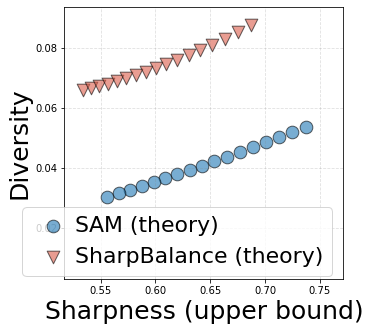

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

ax = axes 

ax.scatter(sharp_SAM[::3], var_SAM[::3], marker='o',        s=160,  alpha=0.6, edgecolors='k', label='SAM (theory)')
ax.scatter(sharp_SharpBal[::3], var_SharpBal[::3], marker='v', s=160,  alpha=0.6, edgecolors='k', color='#db5c49', label='SharpBalance (theory)')

ax.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# ax.set_yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08][::2])
# ax.set_xticks([0.5, 0.6, 0.7, 0.8])
# ax.set_xlim([0.48, 0.8])
ax.set_xlabel('Sharpness (upper bound)', fontsize=25)
ax.set_ylabel('Diversity', fontsize=25)

ax.legend(fontsize=22, loc='lower right', handletextpad=0.01, bbox_to_anchor=(1.0, -0.03))

# Uncomment to save the fig
# plt.savefig(f'./sam_vs_sharpbalance.png', dpi=300, bbox_inches='tight')

### SAM: Theoretical and Simulated Sharpness and Diversity

In [11]:
sharp_est_up_SAM = []
sharp_est_lo_SAM = []
var_est_SAM = []
sharp_sim_SAM = []
var_sim_SAM = []
k_1 = 100
k_2 = 100
k=3
rhos = np.linspace(0.5,0.3, 20)

for rho in rhos:
    sharp,var = sam_var_est(n=n, d_in=d_in, w_hat=w_hat, k=k, rho=rho, eta=eta, sigma_squared=sigma_squared)
    sharp_est_up_SAM.append(sharp[0])
    sharp_est_lo_SAM.append(sharp[1])
    var_est_SAM.append(var)
    
    sharp,var = sam_sim(n=n, d_in=d_in, p=p, k=k, k_0=k_0, k_1=k_1, sigma_squared=sigma_squared, rho=rho, 
                        eta=eta, rho_0=rho_0, w_hat=w_hat)
    sharp_sim_SAM.append(sharp)
    var_sim_SAM.append(var)
    print(f"rho:{rho}, sharp={sharp}, var={var}")

rho:0.5, sharp=11.358687902049315, var=14.55278616795249
rho:0.48947368421052634, sharp=10.81095671881485, var=11.851538159964715
rho:0.4789473684210526, sharp=9.927059991078568, var=10.40199313748669
rho:0.46842105263157896, sharp=9.219847016091808, var=9.262622775955668
rho:0.45789473684210524, sharp=7.75835619084719, var=7.211738107421313
rho:0.4473684210526316, sharp=8.187859625406237, var=6.272606277470129
rho:0.4368421052631579, sharp=7.397890651087527, var=5.162458112896688
rho:0.4263157894736842, sharp=6.284113713936767, var=4.320262244869485
rho:0.41578947368421054, sharp=5.73598046180332, var=3.642230153689661
rho:0.4052631578947368, sharp=5.048708766602067, var=2.949669246287337
rho:0.39473684210526316, sharp=5.109929333237142, var=2.3329966249723
rho:0.38421052631578945, sharp=4.083716993965186, var=1.9075478990179444
rho:0.3736842105263158, sharp=3.895748717204492, var=1.5363925420558984
rho:0.3631578947368421, sharp=3.4846342157243724, var=1.1740771828078547
rho:0.3526315

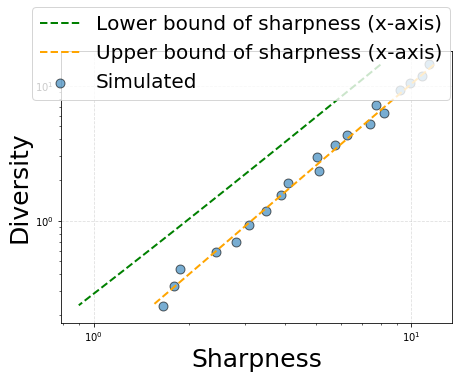

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes 

ax.scatter(sharp_sim_SAM[::1], var_sim_SAM[::1], marker='o', s=80, label='Simulated', alpha=0.6, edgecolors='k')
ax.plot(sharp_est_lo_SAM, var_est_SAM, '--', linewidth=2, color='green', label=rf'Lower bound of sharpness (x-axis)')
ax.plot(sharp_est_up_SAM, var_est_SAM, '--', linewidth=2, color='orange', label=rf'Upper bound of sharpness (x-axis)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

ax.set_xlabel('Sharpness', fontsize=25)
ax.set_ylabel('Diversity', fontsize=25)
ax.legend(fontsize=20, loc='upper left', bbox_to_anchor=(-0.1, 1.2))

# Uncomment to save the fig
# plt.savefig(f'./simulated_estimated_SAM.png', dpi=300, bbox_inches='tight')

### SharpBalance: Theoretical and Simulated Sharpness and Diversity

#### 1) Varying $\rho$:

In [17]:
sharp_est_up_SharpBal = []
var_est_SharpBal = []
sharp_sim_SharpBal = []
var_sim_SharpBal = []
k_1 = 100
k_2 = 100
k=5
eta=0.01
rhos = np.linspace(1.0,0.4, 20)

for rho in rhos:
    sharp,var = sharp_var_est(n=n, d_in=d_in, p=p, s=s, k=k, rho=rho, eta=eta, rho_0=rho_0, 
                              w_hat_norm=np.linalg.norm(w_hat), sigma_squared=sigma_squared)
    sharp_est_up_SharpBal.append(sharp)
    var_est_SharpBal.append(var)
    
    sharp,var = sharpness_sim(n=n, d_in=d_in, p=p, s=s, k=k, k_0=k_0, k_1=k_1, sigma_squared=sigma_squared, 
                              rho=rho, eta=eta, rho_0=rho_0, w_hat=w_hat)
    sharp_sim_SharpBal.append(sharp)
    var_sim_SharpBal.append(var)
    print(f"rho:{rho}, sharp={sharp}, var={var}")

rho:1.0, sharp=0.5029217923141089, var=0.06166811757717085
rho:0.968421052631579, sharp=0.5046703269944096, var=0.06172720173572662
rho:0.9368421052631579, sharp=0.5086556397691389, var=0.06258534296007962
rho:0.9052631578947369, sharp=0.5104357306820362, var=0.06259892900264406
rho:0.8736842105263158, sharp=0.5136292286336115, var=0.06332704740260463
rho:0.8421052631578947, sharp=0.5172303561709555, var=0.06339881397909633
rho:0.8105263157894737, sharp=0.5213548795617868, var=0.06370210497274503
rho:0.7789473684210526, sharp=0.5259653719880646, var=0.06421762167474561
rho:0.7473684210526316, sharp=0.5274555508003118, var=0.0641809133215904
rho:0.7157894736842105, sharp=0.5311753601897479, var=0.06490613924158026
rho:0.6842105263157895, sharp=0.545518037012944, var=0.0660303353081675
rho:0.6526315789473685, sharp=0.5431758938561757, var=0.06607686622188416
rho:0.6210526315789473, sharp=0.5427283431598383, var=0.06601050524462787
rho:0.5894736842105264, sharp=0.553413548989883, var=0.06

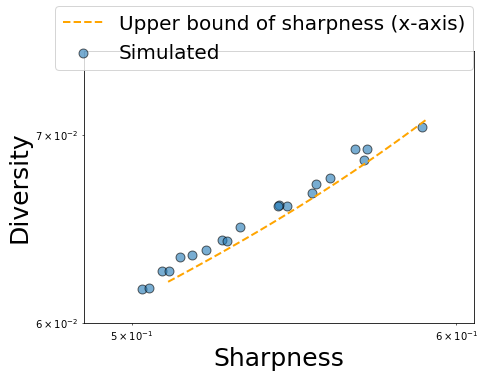

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes 

ax.scatter(sharp_sim_SharpBal[::1], var_sim_SharpBal[::1], marker='o', s=80, label='Simulated', alpha=0.6, edgecolors='k')
ax.plot(sharp_est_up_SharpBal, var_est_SharpBal, '--', linewidth=2, color='orange', label=rf'Upper bound of sharpness (x-axis)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.06, 0.075])
ax.grid(True, linestyle='--', which='major', color='grey', alpha=.25)


ax.set_xlabel('Sharpness', fontsize=25)
ax.set_ylabel('Diversity', fontsize=25)
ax.legend(fontsize=20, loc='upper left', bbox_to_anchor=(-0.1, 1.2))

# Uncomment to save fig
# plt.savefig(f'./simulated_estimated_SharpBal.png', dpi=300, bbox_inches='tight')

#### 2) Varying $k$:

In [19]:
sharp_est_up_SharpBal = []
var_est_SharpBal = []
sharp_sim_SharpBal = []
var_sim_SharpBal = []
k_1 = 100
k_2 = 100
rho = 0.4
ks = range(1,15)

for k in ks:
    sharp,var = sharp_var_est(n=n, d_in=d_in, p=p, s=s, k=k, rho=rho, eta=eta, rho_0=rho_0, 
                              w_hat_norm=np.linalg.norm(w_hat), sigma_squared=sigma_squared)
    sharp_est_up_SharpBal.append(sharp)
    var_est_SharpBal.append(var)
    
    sharp,var = sharpness_sim(n=n, d_in=d_in, p=p, s=s, k=k, k_0=k_0, k_1=k_1, sigma_squared=sigma_squared, 
                              rho=rho, eta=eta, rho_0=rho_0, w_hat=w_hat)
    sharp_sim_SharpBal.append(sharp)
    var_sim_SharpBal.append(var)
    print(f"k:{k}, sharp={sharp}, var={var}")

k:1, sharp=0.6968372809058806, var=0.0905370911458082
k:2, sharp=0.6614018848562437, var=0.08428931491911217
k:3, sharp=0.6334022648899605, var=0.07821142672578538
k:4, sharp=0.6103265928478507, var=0.07391621840363943
k:5, sharp=0.5740109256092595, var=0.07048955686941125
k:6, sharp=0.5581446088486501, var=0.06720532152136219
k:7, sharp=0.5391608936545197, var=0.06397542174729125
k:8, sharp=0.5200328044113463, var=0.061628942143426894
k:9, sharp=0.5019203102423972, var=0.05934085810992264
k:10, sharp=0.48564115091271776, var=0.0574405654135801
k:11, sharp=0.47242131175682545, var=0.05566582367444965
k:12, sharp=0.4543833236836747, var=0.053648080252854016
k:13, sharp=0.4407806344387041, var=0.05205706967652915
k:14, sharp=0.4273298454033686, var=0.051042210959592584


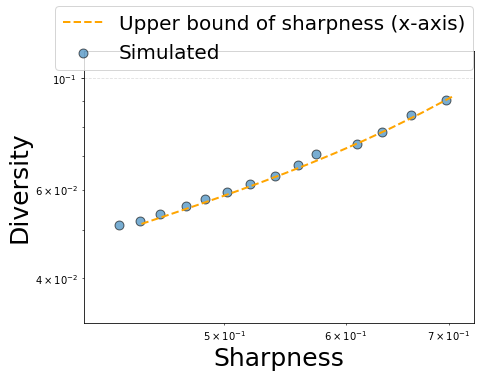

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

ax = axes 

ax.scatter(sharp_sim_SharpBal[::1], var_sim_SharpBal[::1], marker='o', s=80, label='Simulated', alpha=0.6, edgecolors='k')
ax.plot(sharp_est_up_SharpBal, var_est_SharpBal, '--', linewidth=2, color='orange', label=rf'Upper bound of sharpness (x-axis)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(True, linestyle='--', which='major', color='grey', alpha=.25)


ax.set_xlabel('Sharpness', fontsize=25)
ax.set_ylabel('Diversity', fontsize=25)
ax.legend(fontsize=20, loc='upper left', bbox_to_anchor=(-0.1, 1.2))

# Uncomment to save fig
# plt.savefig(f'./simulated_estimated_SharpBal.png', dpi=300, bbox_inches='tight')